# Part One: Binary Classification

Let's read the data

In [ ]:
## library imports here
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures,label_binarize,LabelBinarizer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score,StratifiedKFold
from plotnine import *
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error,accuracy_score,confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,classification_report,roc_curve,auc,cohen_kappa_score
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier,plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("https://www.dropbox.com/s/s2a1uoiegitupjc/cannabis_full.csv?raw=1")

In [ ]:
df= df.dropna()

In [ ]:
df_1 = df[df['Type'].isin(['sativa', 'indica'])]

In [ ]:
df_1= df_1.dropna()
df_1.head(1)

In [ ]:
X = df_1.drop(['Type','Effects','Flavor','Strain'], axis=1)
y = df_1['Type']

## Q1: LDA

Best Metric to use: ROC-AUC gives a more nuanced understanding of the model's performance in classifying cannabis strains since offers a holistic view of the model's predictive power.

In [ ]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [ ]:
# Create pipline
lda_pipeline = Pipeline([
    ("lda", LinearDiscriminantAnalysis())
])
# Fit the model
lda_pipeline.fit(X, y)

Pipeline(steps=[('lda', LinearDiscriminantAnalysis())])

In [ ]:
# Perform cross-validation for accuracy
lda_cv_score = cross_val_score(lda_pipeline, X, y, cv=cv, scoring='roc_auc')
lda_cv_score.mean()

0.9258005281807546

In [ ]:
# Confusion Matrix
lda_predictions = lda_pipeline.predict(X)

class_labels = ['sativa', 'indica']
lda_conf_matrix = confusion_matrix(y, lda_predictions)
pd.DataFrame(lda_conf_matrix,index=class_labels, columns=class_labels)

,sativa,indica
sativa,627,60
indica,86,345


## Q2: QDA

In [ ]:
# Create QDA pipeline
qda_pipeline = Pipeline([
    ("qda", QuadraticDiscriminantAnalysis())
])

# Fit the model
qda_pipeline.fit(X, y)


Pipeline(steps=[('qda', QuadraticDiscriminantAnalysis())])

In [ ]:
# Perform cross-validation for accuracy
qda_cv_score = cross_val_score(qda_pipeline, X, y, cv=cv, scoring='roc_auc')
qda_cv_score.mean()

0.7794697442815715

In [ ]:
# Generate and print the confusion matrix
qda_predictions = qda_pipeline.predict(X)
qda_conf_matrix = confusion_matrix(y, qda_predictions)
pd.DataFrame(qda_conf_matrix,index=class_labels, columns=class_labels)


,sativa,indica
sativa,27,660
indica,0,431


## Q3: SVC

In [ ]:
# Define the pipeline
svc_pipeline = Pipeline([
    ("svc", SVC(kernel="linear"))
])

In [ ]:
# Define the parameter grid for tuning
param_grid = {
    'svc__C': [0.1, 1, 10, 100]  # Example values for C
}

In [ ]:
# Create GridSearchCV object
grid_search = GridSearchCV(svc_pipeline, param_grid, cv=cv,scoring="roc_auc")

# Fit the model
grid_search.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('svc', SVC(kernel='linear'))]),
             param_grid={'svc__C': [0.1, 1, 10, 100]}, scoring='roc_auc')

In [ ]:
cv_results = grid_search.cv_results_

model_scores = pd.DataFrame({'C': cv_results['param_svc__C'], 'mean_test_score': cv_results['mean_test_score']}).sort_values(by='mean_test_score', ascending=False)
model_scores.head()

,C,mean_test_score
0,0.1,0.926778
1,1,0.923997
2,10,0.919271
3,100,0.918797


In [ ]:
svc_pipeline = Pipeline([
    ("svc", SVC(C=0.1,kernel="linear"))
])
svc_pipeline.fit(X, y)

Pipeline(steps=[('svc', SVC(C=0.1, kernel='linear'))])

In [ ]:
svc_cv_score = cross_val_score(svc_pipeline, X, y, cv=cv, scoring='roc_auc')
svc_cv_score.mean()

0.9267778675952411

In [ ]:
# Generate and print the confusion matrix
svc_predictions = svc_pipeline.predict(X)
svc_conf_matrix = confusion_matrix(y, svc_predictions)
pd.DataFrame(svc_conf_matrix,index=class_labels, columns=class_labels )

,sativa,indica
sativa,636,51
indica,99,332


## Q4: SVM

In [ ]:
# Define the SVM pipeline with a polynomial kernel
svm_pipeline = Pipeline([
    ("svm", SVC(kernel='poly'))
])

In [ ]:
# Define the parameter grid for tuning
param_grid_svm = {
    'svm__C': [0.1, 1, 10, 100],  # Regularization parameter
    'svm__degree': [2, 3, 4, 5]      # Polynomial degree
}


In [ ]:
# Create GridSearchCV object for SVM
grid_search_svm = GridSearchCV(svm_pipeline, param_grid_svm, cv=cv, scoring="roc_auc")

# Fit the model
grid_search_svm.fit(X, y)

# Extract grid search results
cv_results_svm = grid_search_svm.cv_results_

In [ ]:
# Create DataFrame to display results
model_scores = pd.DataFrame({'C': cv_results_svm['param_svm__C'],'Degree': cv_results_svm['param_svm__degree'],'mean_test_score': cv_results_svm['mean_test_score']
}).sort_values(by='mean_test_score', ascending=False)

model_scores.head()

,C,Degree,mean_test_score
1,0.1,3,0.933954
3,0.1,5,0.933611
2,0.1,4,0.933581
0,0.1,2,0.932979
5,1,3,0.932073


In [ ]:
svm_pipeline = Pipeline([
    ("svm", SVC(C=0.1,kernel='poly', degree=4))
])

svm_pipeline.fit(X, y)

Pipeline(steps=[('svm', SVC(C=0.1, degree=4, kernel='poly'))])

In [ ]:
svm_cv_score = cross_val_score(svm_pipeline, X, y, cv=cv, scoring='roc_auc')
svm_cv_score.mean()

0.9335806843189524

In [ ]:
# Generate and print the confusion matrix
svm_predictions = svm_pipeline.predict(X)
svm_conf_matrix = confusion_matrix(y, svm_predictions)
pd.DataFrame(svm_conf_matrix,index=class_labels, columns=class_labels )

,sativa,indica
sativa,651,36
indica,125,306


# Part Two: Natural Multiclass

In [ ]:
X = df.drop(['Type','Effects','Flavor','Strain'], axis=1)
y = df['Type']

## Q1 Fit a decision tree, plot the final fit, and interpret the results.



In [ ]:
my_pipeline_dt = Pipeline([
    ("decision_tree", DecisionTreeClassifier())])

In [ ]:
param_grid = {'decision_tree__max_depth': [1, 3, 6, 9, 12, 15]}

In [ ]:
# Grid search with cross-validation
grid_search_dt = GridSearchCV(my_pipeline_dt, param_grid, cv=cv, scoring='roc_auc')

gscv_fitted_dt = grid_search_dt.fit(X, y)
cv_results_dt = gscv_fitted_dt.cv_results_

In [ ]:
# Extracting the scores and parameters from the results
model_scores_dt = pd.DataFrame({
    'Max Depth': cv_results_dt['param_decision_tree__max_depth'],
    'Mean ROC-AUC Score': cv_results_dt['mean_test_score']
}).sort_values(by='Mean ROC-AUC Score', ascending=False)
model_scores_dt

,Max Depth,Mean ROC-AUC Score
0,1,NaN
1,3,NaN
2,6,NaN
3,9,NaN
4,12,NaN
5,15,NaN


In [ ]:
my_pipeline_dt = Pipeline([
    ("decision_tree", DecisionTreeClassifier(max_depth=3))])
my_pipeline_dt.fit(X, y)

Pipeline(steps=[('decision_tree', DecisionTreeClassifier(max_depth=3))])

In [ ]:
dt_cv_score = cross_val_score(my_pipeline_dt, X, y, cv=cv, scoring='accuracy')
dt_cv_score.mean()

0.622155091285526

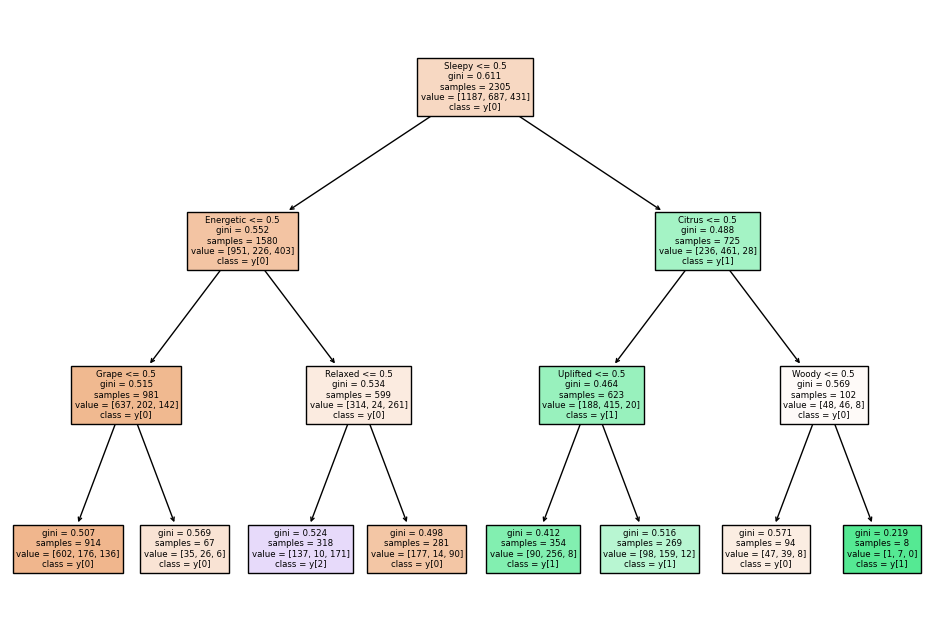

In [ ]:
# Visualize the decision tree
plt.figure(figsize=(12, 8))
decision_tree_model = my_pipeline_dt.named_steps['decision_tree']
plot_tree(decision_tree_model, filled=True, feature_names=X.columns, class_names=True)
plt.show()


In the decision tree model for cannabis strain classification, the features "energetic," "sleepy," and "relaxed" are identified as the most significant. This is indicated by their early appearance in the tree's splits, suggesting a strong influence in differentiating between Sativa, Indica, and Hybrid strains. These features reflect key characteristics associated with each strain type, such as Sativa strains typically being energizing and Indica strains being more likely to induce relaxation or sleepiness.

## Q2 Repeat the analyses from Part One for LDA, QDA, and KNN.

### LDA

Best metric: Accuracy is an ideal metric here because it simply tells us how often the model is right, which works well when the classes are evenly distributed and there's no major difference in the impact of misclassifying one class over the other.

In [ ]:
# Create pipline
lda_pipeline = Pipeline([
    ("lda", LinearDiscriminantAnalysis())
])
# Fit the model
lda_pipeline.fit(X, y)

Pipeline(steps=[('lda', LinearDiscriminantAnalysis())])

In [ ]:
# Perform cross-validation for accuracy
lda_cv_score = cross_val_score(lda_pipeline, X, y, cv=cv, scoring='accuracy')
lda_cv_score.mean()

0.6234669678147939

In [ ]:
# Confusion Matrix
lda_predictions = lda_pipeline.predict(X)

class_labels = ['sativa', 'indica', 'hybrid']
lda_conf_matrix = confusion_matrix(y, lda_predictions)
pd.DataFrame(lda_conf_matrix, index=class_labels, columns=class_labels)

,sativa,indica,hybrid
sativa,829,211,147
indica,211,467,9
hybrid,224,21,186


### QDA

In [ ]:
# Create QDA pipeline
qda_pipeline = Pipeline([
    ("qda", QuadraticDiscriminantAnalysis())
])

# Fit the model
qda_pipeline.fit(X, y)


Pipeline(steps=[('qda', QuadraticDiscriminantAnalysis())])

In [ ]:
# Perform cross-validation for accuracy
qda_cv_score = cross_val_score(qda_pipeline, X, y, cv=cv, scoring='accuracy')
qda_cv_score.mean()

0.20044795783926223

In [ ]:
# Generate and print the confusion matrix
qda_predictions = qda_pipeline.predict(X)
qda_conf_matrix = confusion_matrix(y, qda_predictions)
pd.DataFrame(qda_conf_matrix, index=class_labels, columns=class_labels)


,sativa,indica,hybrid
sativa,21,12,1154
indica,6,26,655
hybrid,0,0,431


### KNN

In [ ]:
# Create the KNN pipeline
my_pipeline_knn = Pipeline([
    ("knn", KNeighborsClassifier())])

param_grid_knn = {
    'knn__n_neighbors': [1, 3, 5, 10, 50, 100]
}


In [ ]:
grid_search_knn = GridSearchCV(my_pipeline_knn, param_grid_knn, cv=cv, scoring='accuracy')
gscv_fitted = grid_search_knn.fit(X, y)

# Create a DataFrame to display grid search results
test_score_1 = gscv_fitted.cv_results_['mean_test_score']
dat1 = pd.DataFrame({'knn__n_neighbors': param_grid_knn['knn__n_neighbors'], 'scores': test_score_1}).sort_values('scores', ascending=False)
dat1

,knn__n_neighbors,scores
4,50,0.606108
5,100,0.604372
3,10,0.589586
2,5,0.587860
1,3,0.571397
0,1,0.508041


In [ ]:
my_pipeline_knn = Pipeline([
    ("knn", KNeighborsClassifier(n_neighbors=50))])
my_pipeline_knn.fit(X, y)

Pipeline(steps=[('knn', KNeighborsClassifier(n_neighbors=50))])

In [ ]:
# Perform cross-validation for accuracy
knn_cv_score = cross_val_score(my_pipeline_knn, X, y, cv=cv, scoring='accuracy')
knn_cv_score.mean()

0.6061076604554866

In [ ]:
y_pred_knn = my_pipeline_knn.predict(X)
class_labels = ['sativa', 'indica', 'hybrid']
knn_conf_matrix = confusion_matrix(y, y_pred_knn)
pd.DataFrame(knn_conf_matrix, index=class_labels, columns=class_labels)

,sativa,indica,hybrid
sativa,959,186,42
indica,276,409,2
hybrid,345,19,67


## Q3 Were your metrics better or worse than in Part One? Why? Which categories were most likely to get mixed up, according to the confusion matrices? Why?


The best-performing model was the one that most accurately distinguished each strain from the others, with particular difficulty observed in correctly identifying Hybrid strains. This is due to Hybrids exhibiting a mix of characteristics from both Indica and Sativa, leading to a significant overlap that complicates classification. The challenge was reflected in lower performance metrics for the Hybrid category in part 2 of the analysis, demonstrating the inherent complexities of multiclass classification. These results, particularly the confusion matrix findings, highlight the nuanced nature of categorizing strains that share properties, underscoring the challenges in distinguishing hybrids in a multiclass setting.

# Part Three: Multiclass from Binary

## Q1

In [ ]:
df_h= df.copy()
df_s= df.copy()
df_i= df.copy()

In [ ]:
df_i['is_indica'] = (df_i['Type'] == 'indica').astype(int)
df_s['is_sativa'] = (df_s['Type'] == 'sativa').astype(int)
df_h['is_hybrid'] = (df_h['Type'] == 'hybrid').astype(int)

In [ ]:
X = df_i.drop(['Type', 'is_indica','Effects','Flavor','Strain'], axis=1)

### Indica vs. Not Indica

#### Logistic regression

In [ ]:
y = df_i['is_indica']

In [ ]:
pipeline_logreg = Pipeline([("logreg", LogisticRegression(penalty='elasticnet', solver='saga'))])

In [ ]:
# Tuning using Grid Search
params = {'logreg__C': [.0001, .001, .01, .1, 1, 10],
          'logreg__l1_ratio':[.1, .2, .4, .6, .8, .9]}

gscv_logreg = GridSearchCV(pipeline_logreg, params, cv=cv, scoring='f1_macro')
gscv_fitted_logreg = gscv_logreg.fit(X, y)

In [ ]:
# Extracting the scores and parameters
mean_test_scores = gscv_fitted_logreg.cv_results_['mean_test_score']
lambdas = gscv_fitted_logreg.cv_results_['param_logreg__C']
alphas = gscv_fitted_logreg.cv_results_['param_logreg__l1_ratio']

# Creating a DataFrame with best parameters and scores
model_scores_logreg = pd.DataFrame({"lambdas": lambdas, "alphas": alphas, "f1_score": mean_test_scores}).sort_values(by='f1_score', ascending=False)
model_scores_logreg.head()

,lambdas,alphas,f1_score
28,1,0.8,0.754051
23,0.1,0.9,0.753312
29,1,0.9,0.753200
21,0.1,0.6,0.753168
27,1,0.6,0.753053


#### SVC

In [ ]:
pipeline_svc = Pipeline([("svc", SVC(kernel="linear"))])

params = {'svc__C': [0.1, 1, 10]}

gscv_svc = GridSearchCV(pipeline_svc, params, cv=cv, scoring='f1_macro')
gscv_fitted_svc = gscv_svc.fit(X, y)

mean_test_scores = gscv_fitted_svc.cv_results_['mean_test_score']
C_values = gscv_svc.cv_results_['param_svc__C'].data

model_scores_svc = pd.DataFrame({"C": C_values, "f1_score": mean_test_scores}).sort_values(by='f1_score', ascending=False)
model_scores_svc

,C,f1_score
1,1,0.750060
0,0.1,0.749879
2,10,0.748854


### Sativa vs. Not Sativa

In [ ]:
y = df_s['is_sativa']

#### Logistic regression

In [ ]:
pipeline_logreg = Pipeline([("logreg", LogisticRegression(penalty='elasticnet', solver='saga'))])

In [ ]:
# Tuning using Grid Search
params = {'logreg__C': [.0001, .001, .01, .1, 1, 10],
          'logreg__l1_ratio':[.1, .2, .4, .6, .8, .9]}

gscv_logreg = GridSearchCV(pipeline_logreg, params, cv=cv, scoring='f1_macro')
gscv_fitted_logreg = gscv_logreg.fit(X, y)

In [ ]:
# Extracting the scores and parameters
mean_test_scores = gscv_fitted_logreg.cv_results_['mean_test_score']
lambdas = gscv_fitted_logreg.cv_results_['param_logreg__C']
alphas = gscv_fitted_logreg.cv_results_['param_logreg__l1_ratio']

# Creating a DataFrame with best parameters and scores
model_scores_logreg = pd.DataFrame({"lambdas": lambdas, "alphas": alphas, "f1_score": mean_test_scores}).sort_values(by='f1_score', ascending=False)
model_scores_logreg.head()

,lambdas,alphas,f1_score
32,10,0.4,0.645400
31,10,0.2,0.645400
30,10,0.1,0.645400
35,10,0.9,0.643409
34,10,0.8,0.643409


#### SVC

In [ ]:
pipeline_svc = Pipeline([("svc", SVC(kernel="linear"))])

params = {'svc__C': [0.1, 1, 10]}

gscv_svc = GridSearchCV(pipeline_svc, params, cv=cv, scoring='f1_macro')
gscv_fitted_svc = gscv_svc.fit(X, y)

mean_test_scores = gscv_fitted_svc.cv_results_['mean_test_score']
C_values = gscv_svc.cv_results_['param_svc__C'].data

model_scores_svc = pd.DataFrame({"C": C_values, "f1_score": mean_test_scores}).sort_values(by='f1_score', ascending=False)
model_scores_svc

,C,f1_score
2,10,0.507717
1,1,0.490616
0,0.1,0.448432


### Hybrid vs. Not Hybrid

In [ ]:
y = df_h['is_hybrid']

#### Logistic regression

In [ ]:
pipeline_logreg = Pipeline([("logreg", LogisticRegression(penalty='elasticnet', solver='saga'))])

In [ ]:
# Tuning using Grid Search
params = {'logreg__C': [.0001, .001, .01, .1, 1, 10],
          'logreg__l1_ratio':[.1, .2, .4, .6, .8, .9]}

gscv_logreg = GridSearchCV(pipeline_logreg, params, cv=cv, scoring='f1_macro')
gscv_fitted_logreg = gscv_logreg.fit(X, y)

In [ ]:
# Extracting the scores and parameters
mean_test_scores = gscv_fitted_logreg.cv_results_['mean_test_score']
lambdas = gscv_fitted_logreg.cv_results_['param_logreg__C']
alphas = gscv_fitted_logreg.cv_results_['param_logreg__l1_ratio']

# Creating a DataFrame with best parameters and scores
model_scores_logreg = pd.DataFrame({"lambdas": lambdas, "alphas": alphas, "f1_score": mean_test_scores}).sort_values(by='f1_score', ascending=False)
model_scores_logreg.head()

,lambdas,alphas,f1_score
25,1,0.2,0.625307
31,10,0.2,0.625292
30,10,0.1,0.624867
24,1,0.1,0.624510
32,10,0.4,0.624390


#### SVC

In [ ]:
pipeline_svc = Pipeline([("svc", SVC(kernel="linear"))])

params = {'svc__C': [0.1, 1, 10]}

gscv_svc = GridSearchCV(pipeline_svc, params, cv=cv, scoring='f1')
gscv_fitted_svc = gscv_svc.fit(X, y)

mean_test_scores = gscv_fitted_svc.cv_results_['mean_test_score']
C_values = gscv_svc.cv_results_['param_svc__C'].data

model_scores_svc = pd.DataFrame({"C": C_values, "f1_score": mean_test_scores}).sort_values(by='f1_score', ascending=False)
model_scores_svc

,C,f1_score
0,0.1,0.685074
1,1,0.676824
2,10,0.673842


## Q2

Logistic Regression outperformed the Support Vector Classifier (SVC) due to its simplicity, efficiency, and probabilistic nature, which are advantageous in handling less complex relationships and ambiguous class boundaries. The underperformance of SVC can be attributed to its greater complexity, computational intensity, and sensitivity to hyperparameter tuning, making it less suitable for datasets without intricate decision boundaries. Classifying Hybrid strains posed additional challenges, as their characteristics, being a mix of Indica and Sativa, often overlap, introducing variability and noise into the dataset. This, coupled with potential inconsistencies in labeling hybrids, complicated the task, leading to lower classification accuracy for these strains.

## Q3

### Indica vs. Sativa

In [ ]:
df_indica_sativa = df[(df['Type'] == 'indica') | (df['Type'] == 'sativa')]

In [ ]:
X = df_indica_sativa.drop(['Type','Effects','Flavor','Strain'], axis=1)
y = df_indica_sativa['Type']

#### Logistic Regression

In [ ]:
pipeline_logreg = Pipeline([("logreg", LogisticRegression(penalty='elasticnet', solver='saga'))])

In [ ]:
# Tuning using Grid Search
params = {'logreg__C': [.0001, .001, .01, .1, 1, 10],
          'logreg__l1_ratio':[.1, .2, .4, .6, .8, .9]}

gscv_logreg = GridSearchCV(pipeline_logreg, params, cv=cv, scoring='roc_auc')
gscv_fitted_logreg = gscv_logreg.fit(X, y)

In [ ]:
# Extracting the scores and parameters
mean_test_scores = gscv_fitted_logreg.cv_results_['mean_test_score']
lambdas = gscv_fitted_logreg.cv_results_['param_logreg__C']
alphas = gscv_fitted_logreg.cv_results_['param_logreg__l1_ratio']

# Creating a DataFrame with best parameters and scores
model_scores_logreg = pd.DataFrame({"lambdas": lambdas, "alphas": alphas, "roc_auc": mean_test_scores}).sort_values(by='roc_auc', ascending=False)
model_scores_logreg.head()

,lambdas,alphas,roc_auc
18,0.1,0.1,0.934258
19,0.1,0.2,0.933783
20,0.1,0.4,0.932078
25,1,0.2,0.930749
24,1,0.1,0.930578


#### SVC

In [ ]:
pipeline_svc = Pipeline([("svc", SVC(kernel="linear"))])

params = {'svc__C': [0.1, 1, 10]}

gscv_svc = GridSearchCV(pipeline_svc, params, cv=cv, scoring='roc_auc')
gscv_fitted_svc = gscv_svc.fit(X, y)

mean_test_scores = gscv_fitted_svc.cv_results_['mean_test_score']
C_values = gscv_svc.cv_results_['param_svc__C'].data

model_scores_svc = pd.DataFrame({"C": C_values, "roc_auc": mean_test_scores}).sort_values(by='roc_auc', ascending=False)
model_scores_svc

,C,roc_auc
0,0.1,0.926778
1,1,0.923997
2,10,0.919271


### Indica vs. Hybrid

In [ ]:
df_indica_sativa = df[(df['Type'] == 'indica') | (df['Type'] == 'hybrid')]

In [ ]:
X = df_indica_sativa.drop(['Type','Effects','Flavor','Strain'], axis=1)
y = df_indica_sativa['Type']

#### Logistic Regression

In [ ]:
pipeline_logreg = Pipeline([("logreg", LogisticRegression(penalty='elasticnet', solver='saga'))])

In [ ]:
# Tuning using Grid Search
params = {'logreg__C': [.0001, .001, .01, .1, 1, 10],
          'logreg__l1_ratio':[.1, .2, .4, .6, .8, .9]}

gscv_logreg = GridSearchCV(pipeline_logreg, params, cv=cv, scoring='roc_auc')
gscv_fitted_logreg = gscv_logreg.fit(X, y)

In [ ]:
# Extracting the scores and parameters
mean_test_scores = gscv_fitted_logreg.cv_results_['mean_test_score']
lambdas = gscv_fitted_logreg.cv_results_['param_logreg__C']
alphas = gscv_fitted_logreg.cv_results_['param_logreg__l1_ratio']

# Creating a DataFrame with best parameters and scores
model_scores_logreg = pd.DataFrame({"lambdas": lambdas, "alphas": alphas, "roc_auc": mean_test_scores}).sort_values(by='roc_auc', ascending=False)
model_scores_logreg.head()

,lambdas,alphas,roc_auc
21,0.1,0.6,0.810503
20,0.1,0.4,0.810236
18,0.1,0.1,0.810100
19,0.1,0.2,0.810032
22,0.1,0.8,0.808694


#### SVC

In [ ]:
pipeline_svc = Pipeline([("svc", SVC(kernel="linear"))])

params = {'svc__C': [0.1, 1, 10]}

gscv_svc = GridSearchCV(pipeline_svc, params, cv=cv, scoring='roc_auc')
gscv_fitted_svc = gscv_svc.fit(X, y)

mean_test_scores = gscv_fitted_svc.cv_results_['mean_test_score']
C_values = gscv_svc.cv_results_['param_svc__C'].data

model_scores_svc = pd.DataFrame({"C": C_values, "roc_auc": mean_test_scores}).sort_values(by='roc_auc', ascending=False)
model_scores_svc

,C,roc_auc
0,0.1,0.789501
1,1,0.782056
2,10,0.772776


### Hybrid vs. Sativa

In [ ]:
df_indica_sativa = df[(df['Type'] == 'hybrid') | (df['Type'] == 'sativa')]

In [ ]:
X = df_indica_sativa.drop(['Type','Effects','Flavor','Strain'], axis=1)
y = df_indica_sativa['Type']

#### Logistic Regression

In [ ]:
pipeline_logreg = Pipeline([("logreg", LogisticRegression(penalty='elasticnet', solver='saga'))])

In [ ]:
# Tuning using Grid Search
params = {'logreg__C': [.0001, .001, .01, .1, 1, 10],
          'logreg__l1_ratio':[.1, .2, .4, .6, .8, .9]}

gscv_logreg = GridSearchCV(pipeline_logreg, params, cv=cv, scoring='roc_auc')
gscv_fitted_logreg = gscv_logreg.fit(X, y)

In [ ]:
# Extracting the scores and parameters
mean_test_scores = gscv_fitted_logreg.cv_results_['mean_test_score']
lambdas = gscv_fitted_logreg.cv_results_['param_logreg__C']
alphas = gscv_fitted_logreg.cv_results_['param_logreg__l1_ratio']

# Creating a DataFrame with best parameters and scores
model_scores_logreg = pd.DataFrame({"lambdas": lambdas, "alphas": alphas, "roc_auc": mean_test_scores}).sort_values(by='roc_auc', ascending=False)
model_scores_logreg.head()

,lambdas,alphas,roc_auc
23,0.1,0.9,0.743461
22,0.1,0.8,0.743010
21,0.1,0.6,0.742885
12,0.01,0.1,0.741658
18,0.1,0.1,0.741122


#### SVC

In [ ]:
pipeline_svc = Pipeline([("svc", SVC(kernel="linear"))])

params = {'svc__C': [0.1, 1, 10]}

gscv_svc = GridSearchCV(pipeline_svc, params, cv=cv, scoring='roc_auc')
gscv_fitted_svc = gscv_svc.fit(X, y)

mean_test_scores = gscv_fitted_svc.cv_results_['mean_test_score']
C_values = gscv_svc.cv_results_['param_svc__C'].data

model_scores_svc = pd.DataFrame({"C": C_values, "roc_auc": mean_test_scores}).sort_values(by='roc_auc', ascending=False)
model_scores_svc

,C,roc_auc
0,0.1,0.730112
1,1,0.727785
2,10,0.725519


## Q4

In a comparative analysis of Logistic Regression and Support Vector Classifier (SVC) for classifying cannabis strains, Logistic Regression consistently outperformed SVC across three binary classifications: Indica vs. Sativa, Indica vs. Hybrid, and Hybrid vs. Sativa. The superiority of Logistic Regression, evident from its higher ROC AUC scores in each case, likely stems from its simplicity, efficiency, and suitability for linear relationships, making it more adept at handling these binary classification tasks. SVC's slightly lower performance in each scenario suggests potential challenges with overfitting or tuning complexities, particularly in distinguishing strains with overlapping characteristics like Hybrids and Sativa, which inherently presents the most challenging differentiation task.

## Q5


Logistic Regression with OvR treats each class as separate from the rest, which is quicker and easier for lots of classes. SVC's OvO method compares every two classes at a time, which is better for more detailed differences.